# Pip Install Libraries for Metric

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d4056332af8fb9c493c7d32aa19789d167c9c24f03d07e0165fb4a7c07917f51
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# Load Train and Test

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")


train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

## efs und efs_time mit KaplanMeier in einem Ziel umwandeln
In diesem Wettbewerb müssen wir den Risk Score vorhersagen. Daher werden wir ein Ziel erstellen, das den Risk Score nachahmt, um unser Modell zu trainieren.

In [3]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

## Survival:Cox braucht dieses Ziel (um efs und efs_time zu verarbeiten)

In [4]:
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

## Features
Es gibt insgesamt 57 Features. Davon sind 35 kategorisch und 22 numerisch. Wir werden die kategorialen Features mit Label Encoding kodieren. Das Modell wird diese dann als kategoriale Features akzeptieren und intern speziell verarbeiten. Die fehlenden Werte (NANs) bei den numerischen Features lassen wir unverändert, da das Modell, das wir trainieren, mit NANs umgehen kann und diese Information nutzen wird.

1. Auswahl der Features

In [5]:
RMV = ["ID","efs","efs_time","y", "efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


2. Identifikation und Bearbeitung von kategorialen Features

In [6]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


3.Dieser Code kombiniert die train- und test-Datensätze, kodiert kategoriale Features mit Label Encoding und konvertiert sie in den category-Typ, reduziert die Präzision numerischer Features auf float32 und int32 zur Speicheroptimierung und teilt die Datensätze anschließend wieder in train und test auf.

In [7]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

## 1. XGBBoost with Survival:Cox and Best Parameters

Hier werden die Modellen importiert

In [8]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [9]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [10]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.2.0


In [11]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=8,
        learning_rate=0.019180186569698675,
        min_child_weight=47,
        subsample=0.9913786724023141,
        colsample_bytree=0.5512042009813181,
        gamma=0.6656834426492644,
        reg_lambda=0.00200760075141747,
        reg_alpha=0.9046362148445268,
        n_estimators=1345,
        max_delta_step=0,
        objective='survival:cox',
        eval_metric='cox-nloglik',
        enable_categorical=True
        #early_stopping_rounds=25,
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.62287
[500]	validation_0-cox-nloglik:7.41368
[1000]	validation_0-cox-nloglik:7.41171
[1344]	validation_0-cox-nloglik:7.41120
#########################
### Fold 2
#########################


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-cox-nloglik:7.61578
[500]	validation_0-cox-nloglik:7.39496
[1000]	validation_0-cox-nloglik:7.39614
[1344]	validation_0-cox-nloglik:7.39756
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.60839
[500]	validation_0-cox-nloglik:7.38773
[1000]	validation_0-cox-nloglik:7.39375
[1344]	validation_0-cox-nloglik:7.39599
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.60374
[500]	validation_0-cox-nloglik:7.39338
[1000]	validation_0-cox-nloglik:7.39788
[1344]	validation_0-cox-nloglik:7.39980
#########################
### Fold 5
#########################
[0]	validation_0-cox-nloglik:7.62772
[500]	validation_0-cox-nloglik:7.40876
[1000]	validation_0-cox-nloglik:7.41214
[1344]	validation_0-cox-nloglik:7.41384
#########################
### Fold 6
#########################
[0]	validation_0-cox-nloglik:7.61141
[500]	validation_0-cox-nloglik:7.40037
[1000]	validation_0-cox-nloglik:7.40989
[1344]	v

In [12]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Cox = 0.6757889573655814


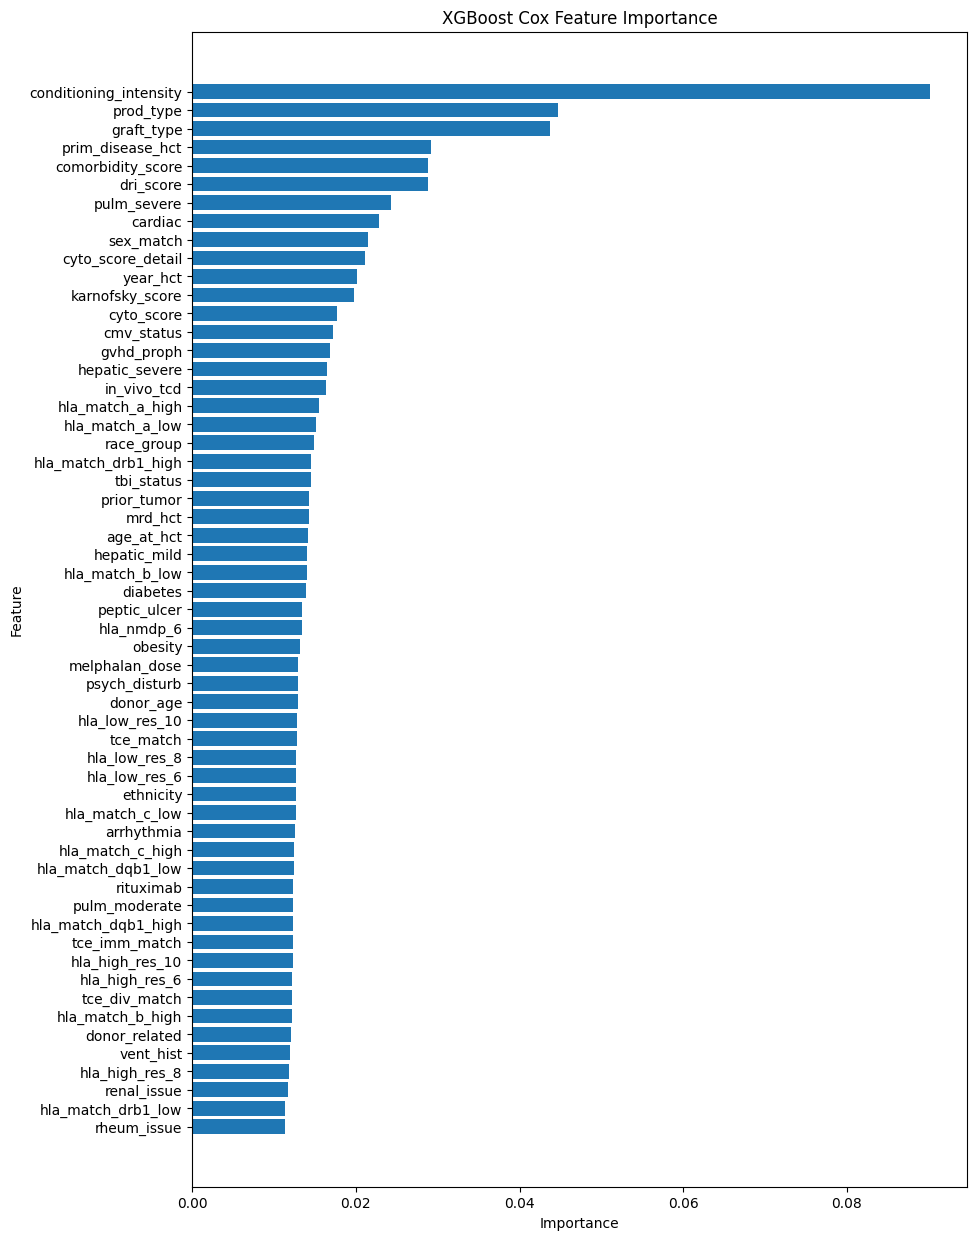

In [13]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 2. XGBoost with KaplanMeier and Best Parameters

In [14]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_kp = np.zeros(len(train))
pred_xgb_kp = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb_kp = XGBRegressor(
        device="cuda",
        max_depth=7,
        learning_rate=0.006837964718704602,
        min_child_weight=44,
        subsample=0.7681058902269439,
        colsample_bytree=0.32840050464339965,
        gamma=0.00032775111883552935,
        reg_lambda=0.020766622076885927,
        reg_alpha=0.008309536388515651,
        n_estimators=2479,
        max_delta_step=0,
        enable_categorical=True
        #early_stopping_rounds=25,
    )
    model_xgb_kp.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb_kp[test_index] = model_xgb_kp.predict(x_valid)
    # INFER TEST
    pred_xgb_kp += model_xgb_kp.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_kp /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17795
[500]	validation_0-rmse:0.16068
[1000]	validation_0-rmse:0.15740
[1500]	validation_0-rmse:0.15617
[2000]	validation_0-rmse:0.15554
[2478]	validation_0-rmse:0.15521
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17377
[500]	validation_0-rmse:0.15652
[1000]	validation_0-rmse:0.15402
[1500]	validation_0-rmse:0.15298
[2000]	validation_0-rmse:0.15246
[2478]	validation_0-rmse:0.15229
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17748
[500]	validation_0-rmse:0.15903
[1000]	validation_0-rmse:0.15597
[1500]	validation_0-rmse:0.15481
[2000]	validation_0-rmse:0.15424
[2478]	validation_0-rmse:0.15398
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17945
[500]	validation_0-rmse:0.16129
[1000]	validation_0-rmse:0.15823
[1500]	validation_0-rmse:0.15711
[2000]	validation_0-rmse:0.15661
[2478

In [15]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_kp
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBBoost KaplanMeier = 0.675076561304311


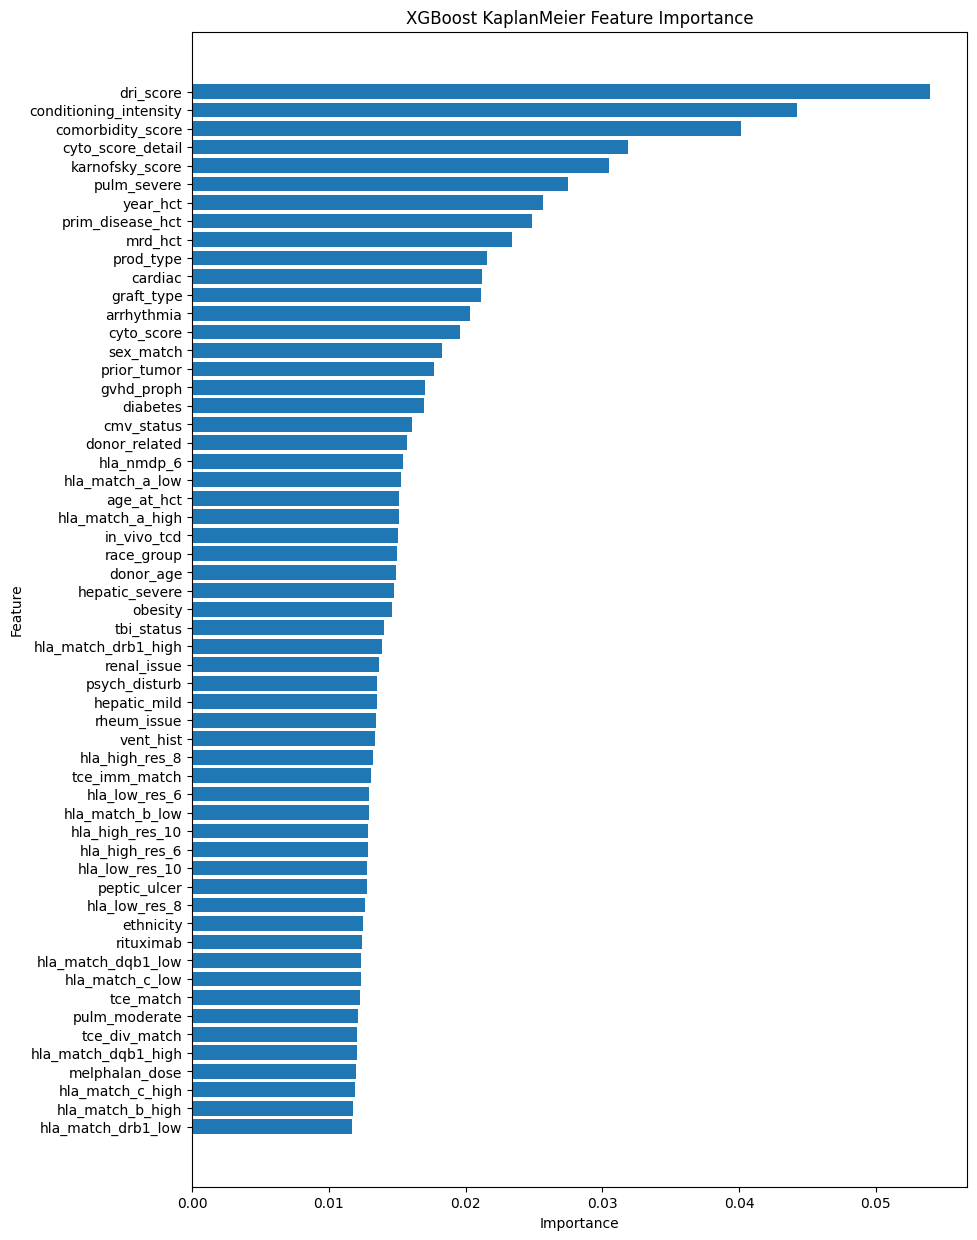

In [16]:
feature_importance = model_xgb_kp.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 3. LightGBM with Kaplan Meier and Best Parameters

In [17]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu",
        objective="regression",
        max_depth=9,
        learning_rate=0.008443870352864884,
        min_child_weight=32,
        subsample=0.7809557131317068,
        colsample_bytree=0.39223312209276945,
        reg_lambda=0.44440510134773026,
        reg_alpha=0.04919098810151467,
        min_split_gain=0.00048235744372199935,
        n_estimators=1579,
        num_leaves=125,
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [18]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for LightGBM KaplanMeier = 0.6735431191761664


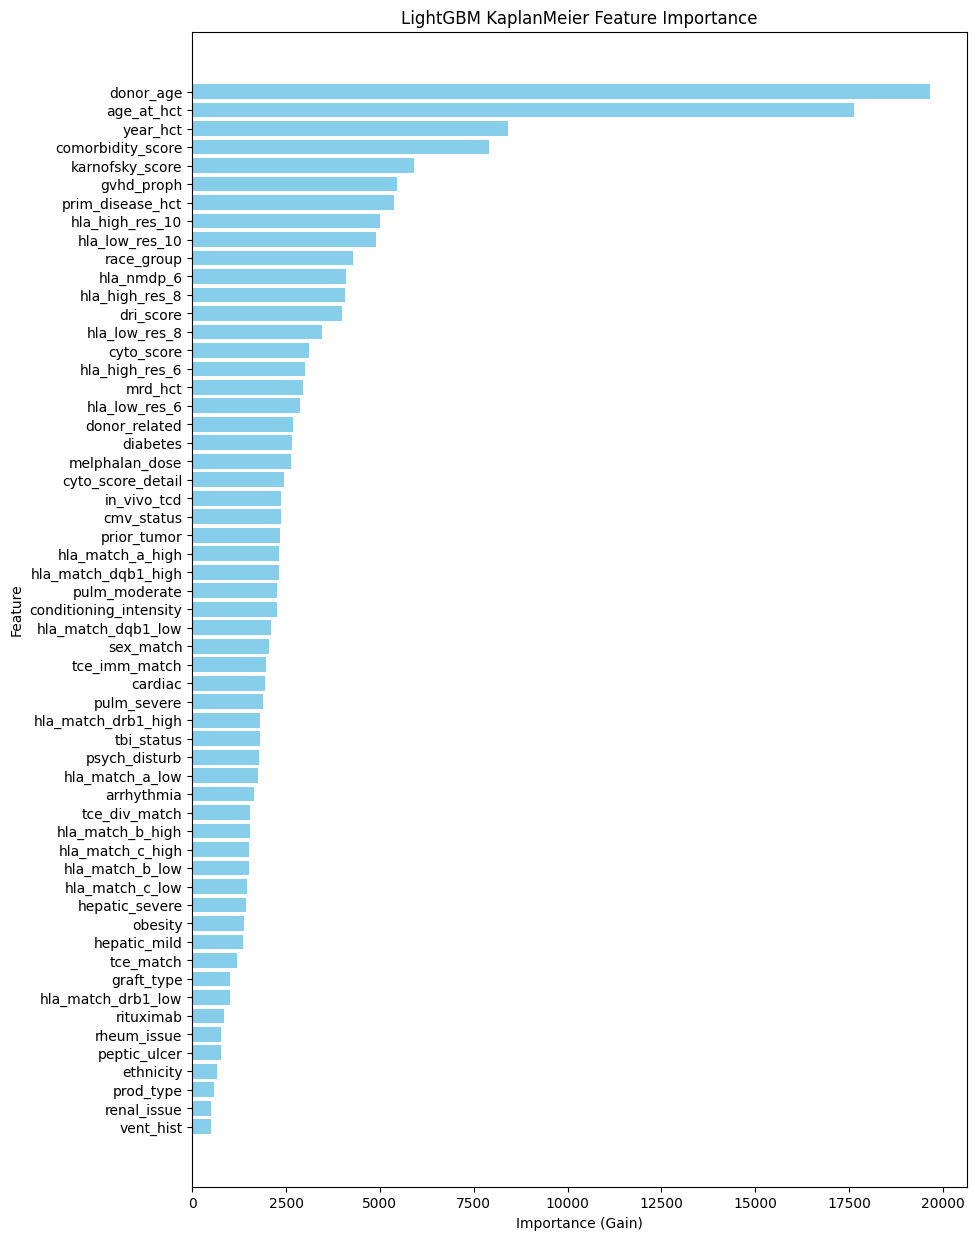

In [19]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 4. CatBoost with Kaplan Meier and Best Parameters

In [20]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_loss = np.zeros(len(train))
pred_cat_loss = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat_loss = CatBoostRegressor(
        task_type="GPU",
        max_depth=8,  
        learning_rate=0.022977710686328142,  
        min_data_in_leaf=12,  
        reg_lambda=0.6555309063998679,  
        n_estimators=1892,
        random_strength=1,
        grow_policy="Lossguide",
        verbose=False
    )
    model_cat_loss.fit(
        x_train, y_train,
        cat_features=CATS,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_cat_loss[test_index] = model_cat_loss.predict(x_valid)
    # INFER TEST
    pred_cat_loss += model_cat_loss.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_loss /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1760230	test: 0.1775426	best: 0.1775426 (0)	total: 3.83s	remaining: 2h 36s
500:	learn: 0.1494764	test: 0.1585890	best: 0.1585890 (500)	total: 8.04s	remaining: 22.3s
1000:	learn: 0.1434093	test: 0.1573608	best: 0.1573570 (995)	total: 12.1s	remaining: 10.8s
1500:	learn: 0.1387074	test: 0.1568303	best: 0.1568280 (1499)	total: 16.1s	remaining: 4.2s
1891:	learn: 0.1353276	test: 0.1564944	best: 0.1564944 (1891)	total: 19.4s	remaining: 0us
bestTest = 0.1564943565
bestIteration = 1891
#########################
### Fold 2
#########################
0:	learn: 0.1764813	test: 0.1733319	best: 0.1733319 (0)	total: 9.45ms	remaining: 17.9s
500:	learn: 0.1498447	test: 0.1543472	best: 0.1543461 (499)	total: 4.14s	remaining: 11.5s
1000:	learn: 0.1436066	test: 0.1534709	best: 0.1534704 (999)	total: 8.32s	remaining: 7.41s
1500:	learn: 0.1388204	test: 0.1531574	best: 0.1531552 (1494)	total: 12.4s	remaining: 3.22s
1891:	learn: 0.13554

In [21]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_loss
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Kaplan =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Kaplan = 0.6750501874134567


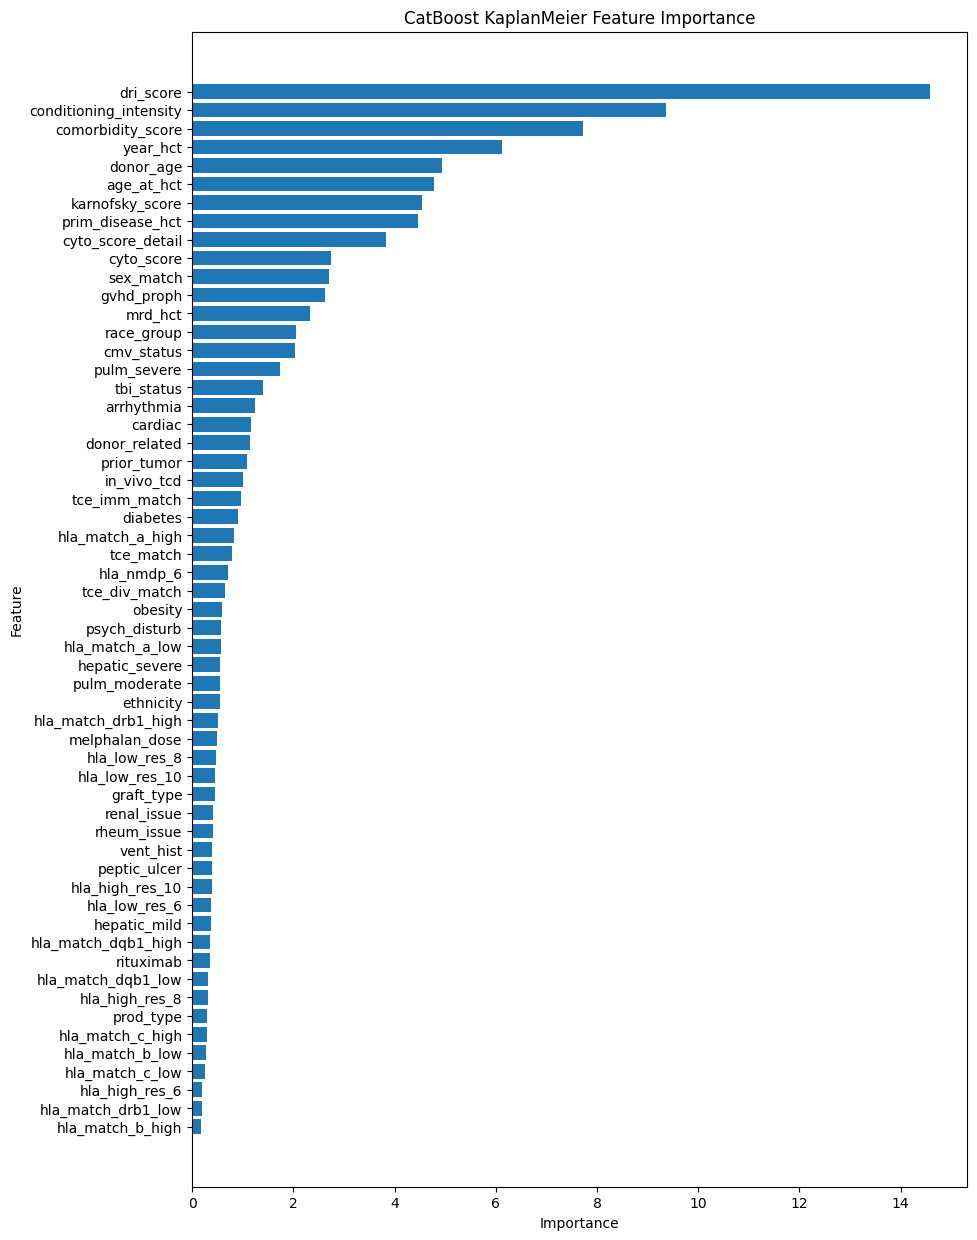

In [22]:
feature_importance = model_cat_loss.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 5. CatBoost with Survival:Cox and Best Parameters

In [23]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_coxb = np.zeros(len(train))
pred_cat_coxb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_coxb = CatBoostRegressor(
        max_depth=9,
        learning_rate=0.0839544,
        min_data_in_leaf=2,
        rsm=0.326722,
        reg_lambda=91.5497,
        n_estimators=2401,
        random_strength=4,
        grow_policy='Lossguide',
        loss_function="Cox",
        bootstrap_type="Bayesian",
        #task_type="GPU",   
    )
    model_cat_coxb.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_coxb[test_index] = model_cat_coxb.predict(x_valid)
    # INFER TEST
    pred_cat_coxb += model_cat_coxb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_coxb /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -137338.4865019	test: -11638.8932160	best: -11638.8932160 (0)	total: 52.1ms	remaining: 2m 4s
100:	learn: -135052.0883748	test: -11404.8399069	best: -11404.8399069 (100)	total: 3.74s	remaining: 1m 25s
200:	learn: -134421.1402243	test: -11355.6354966	best: -11355.6354966 (200)	total: 8.06s	remaining: 1m 28s
300:	learn: -134032.7073971	test: -11341.1649800	best: -11341.1649800 (300)	total: 12.3s	remaining: 1m 25s
400:	learn: -133773.0732744	test: -11336.4254525	best: -11336.3539171 (398)	total: 16.5s	remaining: 1m 22s
500:	learn: -133565.3473756	test: -11332.0977667	best: -11331.8713811 (491)	total: 20.8s	remaining: 1m 18s
600:	learn: -133357.0642913	test: -11328.4544282	best: -11328.3018306 (595)	total: 25s	remaining: 1m 14s
700:	learn: -133171.5144150	test: -11327.2538985	best: -11326.9524836 (678)	total: 29.2s	remaining: 1m 10s
800:	learn: -132996.5604586	test: -11325.3131202	best: -11325.1162544 (795)	total: 33.3

In [24]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_coxb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6730860130077087


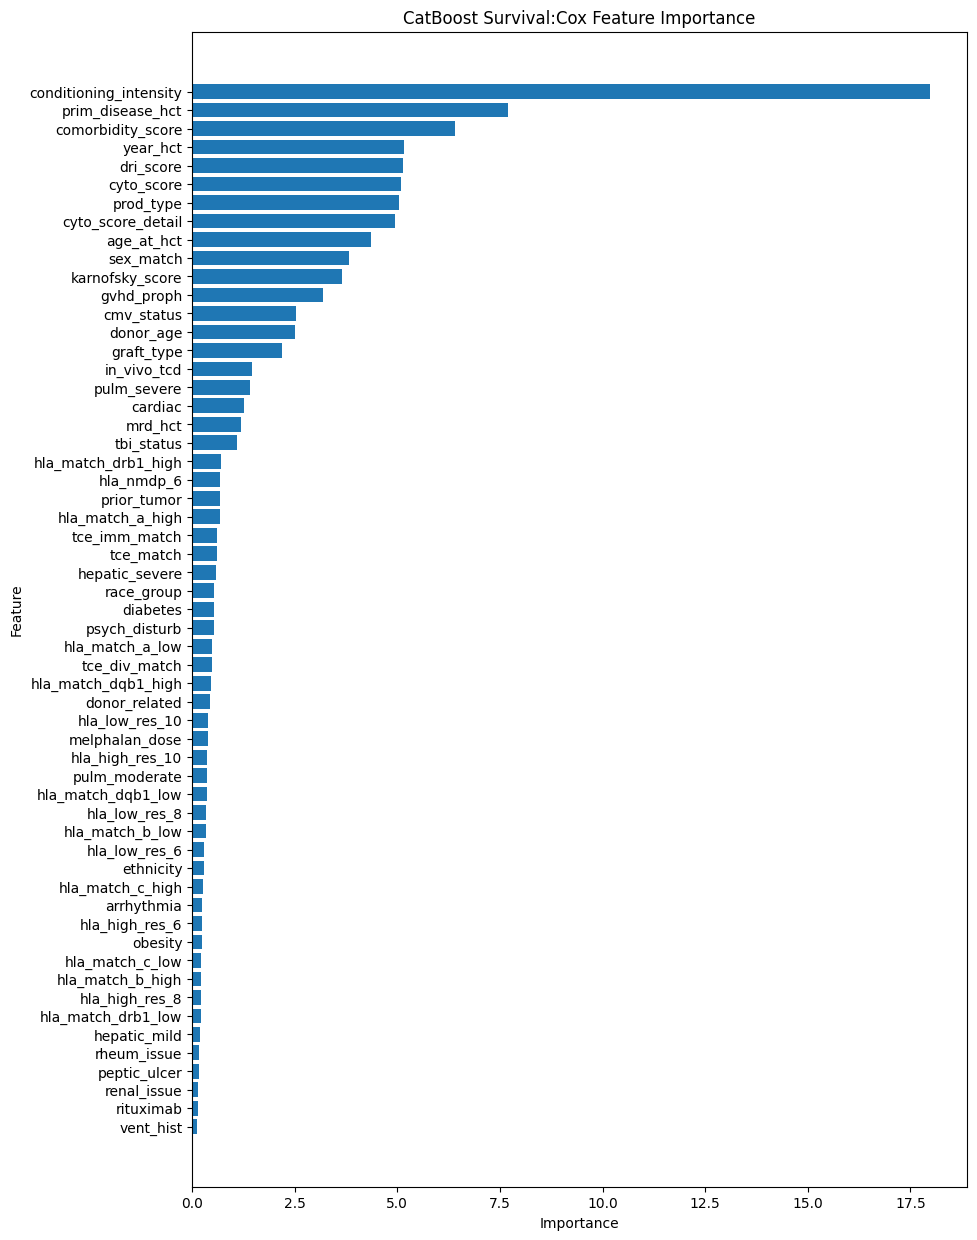

In [25]:
feature_importance = model_cat_coxb.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 6. CatBoost with KaplanMeier: Bayesian/Depthwise and Best Parameters

In [26]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_kpbd= np.zeros(len(train))
pred_cat_kpbd= np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat_kpbd = CatBoostRegressor(
        #task_type="GPU",   
        n_estimators=1793,     
        learning_rate=0.033979276442572245,
        rsm=0.48260603646945244,
        random_strength=8,
        reg_lambda=31.848099030608275,
        min_data_in_leaf=44,
        max_depth=9,
        bagging_temperature=0.31379607904153595,
        grow_policy='Depthwise',
        bootstrap_type="Bayesian",
        use_best_model=False,
    )
    model_cat_kpbd.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_kpbd[test_index] = model_cat_kpbd.predict(x_valid)
    # INFER TEST
    pred_cat_kpbd += model_cat_kpbd.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_kpbd /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1760392	test: 0.1776014	best: 0.1776014 (0)	total: 76.2ms	remaining: 2m 16s
100:	learn: 0.1639794	test: 0.1666919	best: 0.1666919 (100)	total: 4.58s	remaining: 1m 16s
200:	learn: 0.1613502	test: 0.1644049	best: 0.1644049 (200)	total: 8.67s	remaining: 1m 8s
300:	learn: 0.1596027	test: 0.1631359	best: 0.1631359 (300)	total: 12.8s	remaining: 1m 3s
400:	learn: 0.1539174	test: 0.1600146	best: 0.1600146 (400)	total: 17.5s	remaining: 1m
500:	learn: 0.1474027	test: 0.1582824	best: 0.1582824 (500)	total: 22.2s	remaining: 57.2s
600:	learn: 0.1438535	test: 0.1575463	best: 0.1575463 (600)	total: 26.4s	remaining: 52.4s
700:	learn: 0.1415366	test: 0.1571697	best: 0.1571689 (699)	total: 30.4s	remaining: 47.4s
800:	learn: 0.1395016	test: 0.1567502	best: 0.1567502 (800)	total: 35s	remaining: 43.3s
900:	learn: 0.1375000	test: 0.1564719	best: 0.1564719 (900)	total: 39s	remaining: 38.6s
1000:	learn: 0.1354640	test: 0.1563235	best: 

In [27]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_kpbd
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier Bayesian/Depthwise =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier Bayesian/Depthwise = 0.6743454313531053


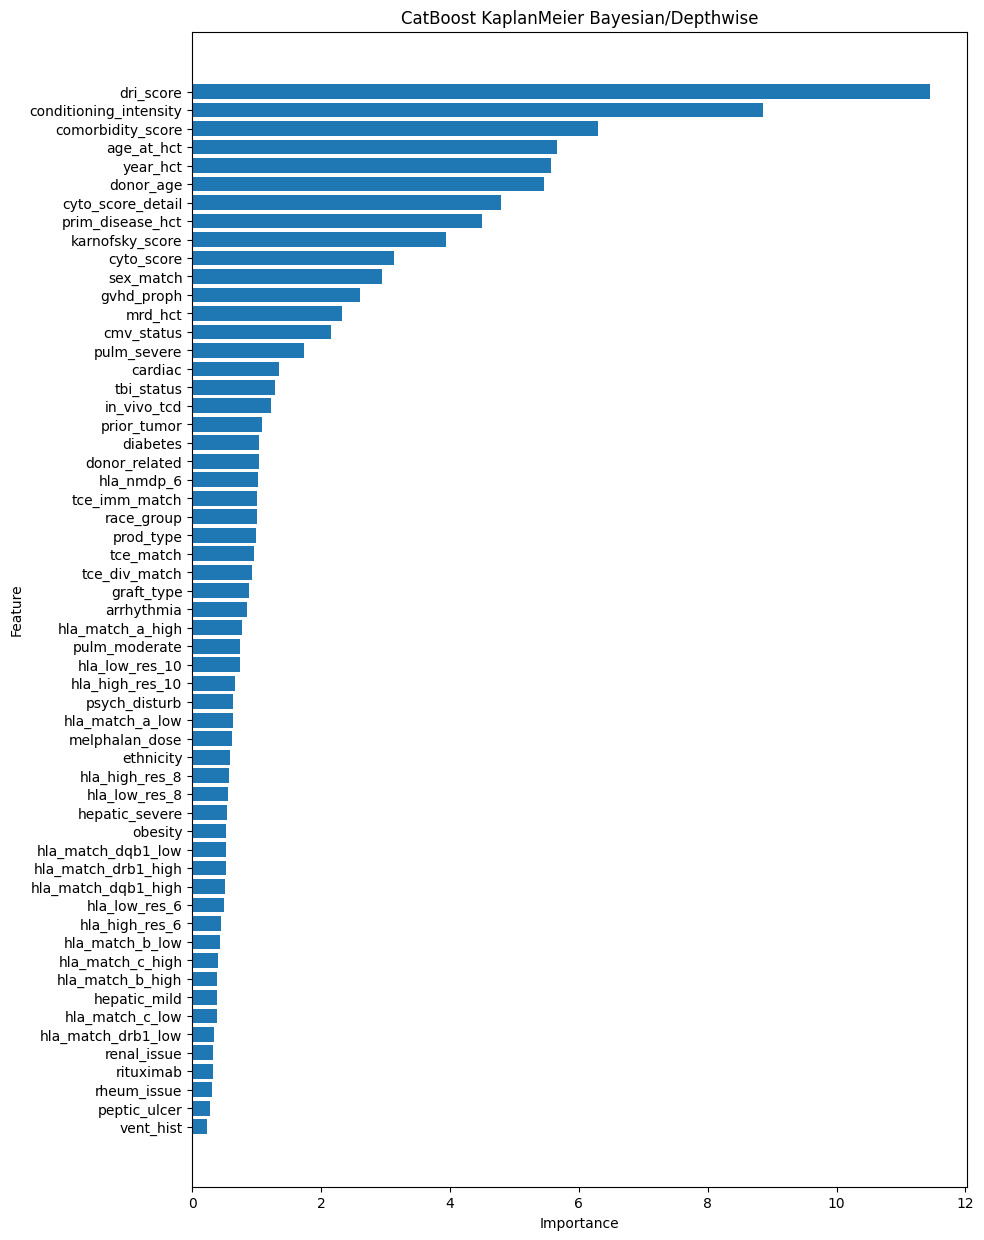

In [28]:
feature_importance = model_cat_kpbd.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Bayesian/Depthwise")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 7. CatBoost with KaplanMeier: Poisson/Lossguide and Best Parameters

In [29]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_poissonl= np.zeros(len(train))
pred_cat_poissonl= np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat_poissonl = CatBoostRegressor(
        task_type="GPU",   
        n_estimators=2023,     
        learning_rate=0.06333683707731051,
        #colsample_bytree=0.48260603646945244,
        random_strength=4,
        reg_lambda=43.72410700362918,
        min_data_in_leaf=17,
        max_depth=5,
        subsample=0.9143719787167877,
        grow_policy='Lossguide',
        bootstrap_type="Poisson",
        use_best_model=False,
    )
    model_cat_poissonl.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_poissonl[test_index] = model_cat_poissonl.predict(x_valid)
    # INFER TEST
    pred_cat_poissonl += model_cat_poissonl.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_poissonl /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1753080	test: 0.1768338	best: 0.1768338 (0)	total: 18.4ms	remaining: 37.2s
100:	learn: 0.1550554	test: 0.1603148	best: 0.1603148 (100)	total: 732ms	remaining: 13.9s
200:	learn: 0.1513507	test: 0.1584389	best: 0.1584330 (199)	total: 1.4s	remaining: 12.6s
300:	learn: 0.1488810	test: 0.1577290	best: 0.1577183 (293)	total: 2.04s	remaining: 11.7s
400:	learn: 0.1469982	test: 0.1571410	best: 0.1571410 (400)	total: 2.68s	remaining: 10.9s
500:	learn: 0.1454021	test: 0.1567994	best: 0.1567989 (499)	total: 3.32s	remaining: 10.1s
600:	learn: 0.1440296	test: 0.1565111	best: 0.1565111 (600)	total: 3.99s	remaining: 9.45s
700:	learn: 0.1426152	test: 0.1563038	best: 0.1562967 (698)	total: 4.69s	remaining: 8.85s
800:	learn: 0.1413228	test: 0.1562140	best: 0.1561937 (771)	total: 5.35s	remaining: 8.17s
900:	learn: 0.1400779	test: 0.1561194	best: 0.1560956 (897)	total: 6.02s	remaining: 7.5s
1000:	learn: 0.1388326	test: 0.1559591	bes

In [30]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_poissonl
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier and Poisson;Loss =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier and Poisson;Loss = 0.6740488437839696


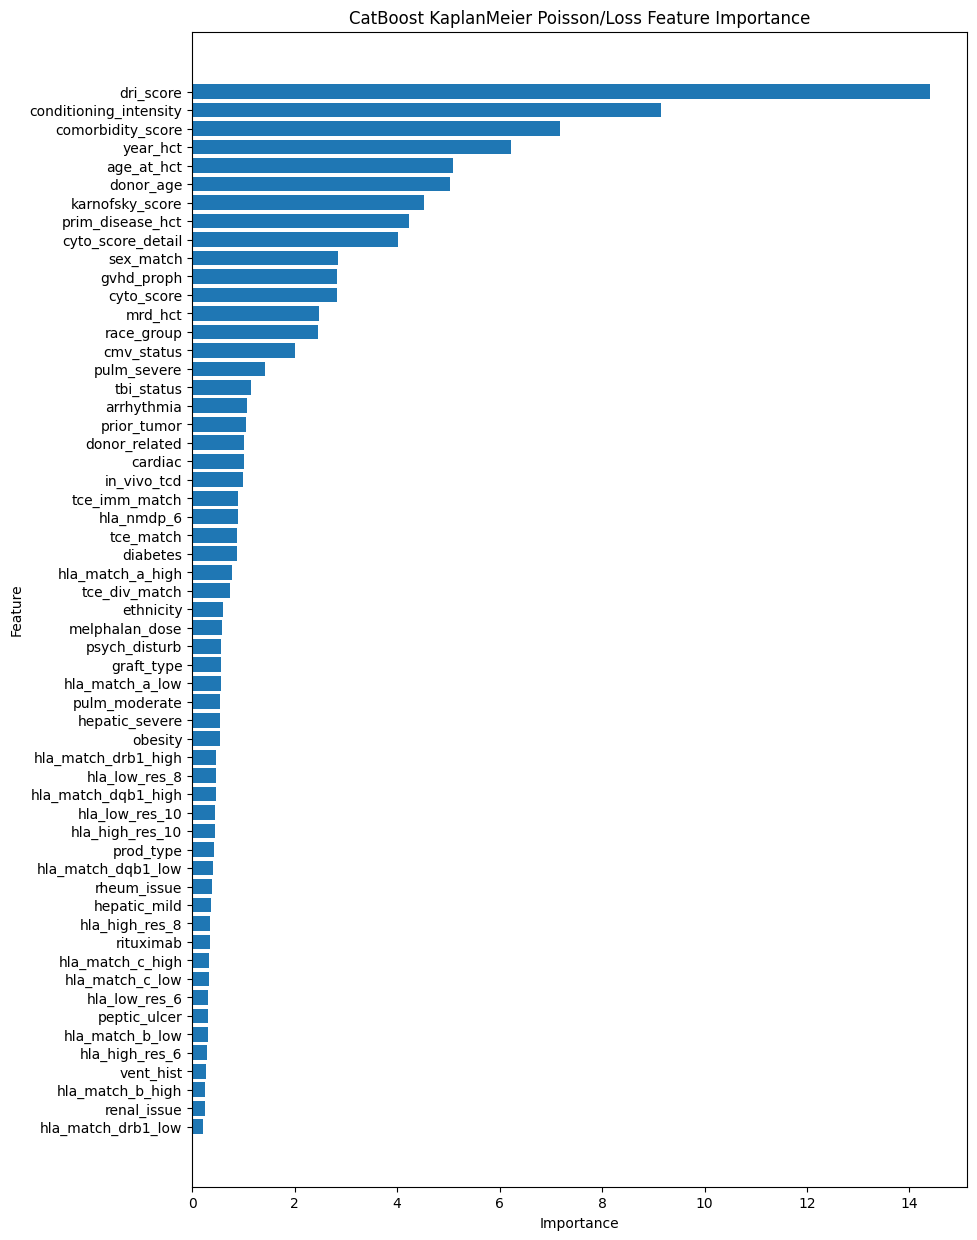

In [31]:
feature_importance = model_cat_poissonl.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Poisson/Loss Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## 8. CatBoost with Kaplan Meier: Poisson/Depthwise and Best Parameters

In [32]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_poissond= np.zeros(len(train))
pred_cat_poissond= np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat_poissond = CatBoostRegressor(
        task_type="GPU",   
        n_estimators=2560,     
        learning_rate=0.016278113324637362,
        #rsm=0.48260603646945244,
        random_strength=9,
        reg_lambda=0.015511658612985226,
        min_data_in_leaf=38,
        max_depth=5,
        subsample=0.9819990443761735,
        grow_policy='Depthwise',
        bootstrap_type="Poisson",
        use_best_model=False,
    )
    model_cat_poissond.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_poissond[test_index] = model_cat_poissond.predict(x_valid)
    # INFER TEST
    pred_cat_poissond += model_cat_poissond.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_poissond /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1762049	test: 0.1777294	best: 0.1777294 (0)	total: 8.46ms	remaining: 21.6s
100:	learn: 0.1623650	test: 0.1657674	best: 0.1657674 (100)	total: 529ms	remaining: 12.9s
200:	learn: 0.1580644	test: 0.1628618	best: 0.1628618 (200)	total: 1.06s	remaining: 12.5s
300:	learn: 0.1553994	test: 0.1612218	best: 0.1612218 (300)	total: 1.57s	remaining: 11.8s
400:	learn: 0.1536320	test: 0.1602482	best: 0.1602482 (400)	total: 2.08s	remaining: 11.2s
500:	learn: 0.1522416	test: 0.1596126	best: 0.1596126 (500)	total: 2.61s	remaining: 10.7s
600:	learn: 0.1509821	test: 0.1590921	best: 0.1590921 (600)	total: 3.15s	remaining: 10.3s
700:	learn: 0.1499228	test: 0.1586475	best: 0.1586475 (700)	total: 3.68s	remaining: 9.76s
800:	learn: 0.1490162	test: 0.1583263	best: 0.1583252 (798)	total: 4.18s	remaining: 9.18s
900:	learn: 0.1481263	test: 0.1580117	best: 0.1580117 (900)	total: 4.71s	remaining: 8.66s
1000:	learn: 0.1473521	test: 0.1577478	b

In [33]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_poissond
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for  CatBoost with KaplanMeier and Poisson:Depthwise =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for  CatBoost with KaplanMeier and Poisson:Depthwise = 0.6752863445906666


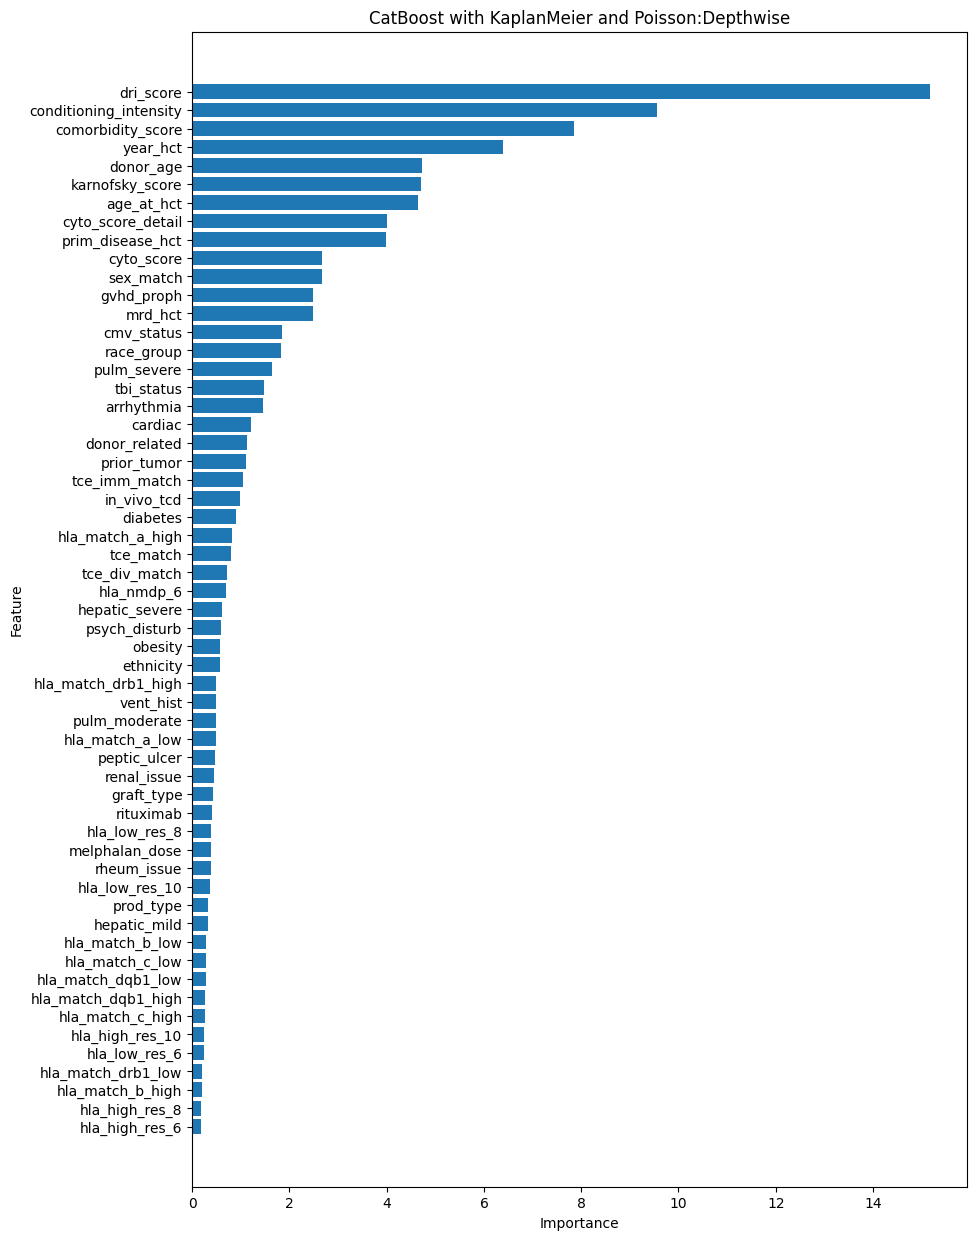

In [34]:
feature_importance = model_cat_poissond.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost with KaplanMeier and Poisson:Depthwise")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# Ensemble all 8 models

In [35]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_cox) + rankdata(oof_xgb_kp) + rankdata(oof_lgb) + rankdata(oof_cat_loss) + rankdata(oof_cat_coxb) + rankdata(oof_cat_kpbd) + rankdata(oof_cat_poissonl) + rankdata(oof_cat_poissond)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6813493744244615


# Create Submission CSV

In [36]:
#sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
#sub.prediction = rankdata(pred_xgb_cox) + rankdata(pred_xgb_kp) + rankdata(pred_lgb) + rankdata(pred_cat_loss) + rankdata(pred_cat_coxb) + rankdata(pred_cat_kpbd) + rankdata(pred_cat_poissonl) + rankdata(pred_cat_poissond)
#sub.to_csv("submission.csv",index=False)
#print("Sub shape:",sub.shape)
#sub.head()